**MILESTONE 2**

**Importing necessary libraries**

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from tabulate import tabulate  # For beautiful tables
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import VotingClassifier
import warnings #importing the warnings module
warnings.filterwarnings('ignore') #filtering the warnings
lgb_model = lgb.LGBMClassifier(verbosity=-1)
xgb_model = xgb.XGBClassifier(verbosity=0)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**READ THE DATASET**

In [74]:
# Load and preprocess the dataset (assume it's already fetched from S3)
# Example dataset - replace with your actual dataset
df = pd.read_csv('/content/Final_cleaned_preprocessed_DataSet.csv')

**PREPROCESS THE DATASET:**

■ Handle missing data, outliers, and normalize/standardize feature values.

■ Perform data transformations if required (e.g., one-hot encoding for categorical data).



In [75]:
# Step 1: Handle Missing Data
print("Missing values before handling:\n", df.isnull().sum())
df = df.fillna(df.mean())  # Fill numerical missing values with column mean
df = df.fillna("Unknown")  # Fill categorical missing values with 'Unknown'

print("\nMissing values after handling:\n", df.isnull().sum())


# Step 2: Detect and Handle Outliers (Using Z-Score)
print("\nNumber of rows before removing outliers:",df.shape[0])

# Calculate Z-scores for numerical columns to identify outliers
z_scores = np.abs(zscore(df.select_dtypes(include=['float64', 'int64'])))

# Define a threshold (e.g., z-score > 3 is an outlier)
df_no_outliers = df[(z_scores < 3).all(axis=1)]
print(f"\nNumber of rows after removing outliers: {df_no_outliers.shape[0]}")


# Step 3: Split Features (X) and Target (y)
X = df_no_outliers.drop('isFraud', axis=1)  # Replace 'is_fraud' with your target column name
y = df_no_outliers['isFraud']

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)
# Step 4: Identify Numerical and Categorical Features
# Explicitly convert 'type' to categorical if it's not already
X['type'] = X['type'].astype('category')  # Ensure 'type' is treated as categorical

numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['category']).columns # Select features with 'category' dtype

print("\nNumerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


# Step 5: Create a ColumnTransformer with MinMaxScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),  # Scale numerical features to [0, 1]
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Step 6: Apply Transformations to the Data
X_transformed = preprocessor.fit_transform(X)

print(f"\nShape of the transformed dataset: {X_transformed.shape}")

# Optional: Convert to DataFrame for inspection
transformed_feature_names = (
    numerical_features.tolist() +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)

print("\nTransformed Data Sample:\n", X_transformed_df.head())


Missing values before handling:
 type              0
amount            0
oldbalanceOrg     0
newbalanceDest    0
isFraud           0
dtype: int64

Missing values after handling:
 type              0
amount            0
oldbalanceOrg     0
newbalanceDest    0
isFraud           0
dtype: int64

Number of rows before removing outliers: 16426

Number of rows after removing outliers: 15581

Shape of X: (15581, 4)
Shape of y: (15581,)

Numerical Features: Index(['amount', 'oldbalanceOrg', 'newbalanceDest'], dtype='object')
Categorical Features: Index(['type'], dtype='object')

Shape of the transformed dataset: (15581, 8)

Transformed Data Sample:
      amount  oldbalanceOrg  newbalanceDest  type_0.0  type_0.25  type_0.5  \
0  0.011975       0.099792        0.166035       1.0        0.0       0.0   
1  0.001974       0.030876        0.000000       0.0        0.0       0.0   
2  0.003579       0.002082        0.000000       0.0        0.0       0.0   
3  0.028585       0.016635        0.000000 

**Transformed dataset:**

In [31]:
df.head()

,type,amount,oldbalanceOrg,newbalanceDest,isFraud
0,0.00,0.002432,0.018398,0.009007,0.0
1,0.75,0.000401,0.005692,0.000000,0.0
2,1.00,0.000727,0.000384,0.000000,1.0
3,1.00,0.005805,0.003067,0.000000,1.0
4,0.25,0.150521,0.079521,0.020016,1.0


**Split the Dataset into Training, Validation, and Testing Sets:**

**○ IMPLEMENTATION**:

■ Use train_test_split() from Scikit-learn to divide the data into three sets.

■ Typical split ratios: 70% for training, 15% for validation, 15% for testing.

**○ Outcome:** Dataset is divided into three subsets for training,

In [76]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [43]:

# Step 1: Split into 85% training+validation and 15% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Step 2: Split the 85% training+validation into 70% training and 15% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%




■ Evaluate several algorithms like

**Decision Trees** - Simple, interpretable but prone to overfitting

**Random Forests** - Reduces overfitting, robust but slower for large datasets

**Logistic Regression** - Limited to linear relationships

**Boosting Algorithms**: Fast, high accuracy



*   XGBoost
*   LightGBM



**Anomaly Detection Algorithm:**

**IsolationForest** - Simple to implement Slow for large datasets

**Ensemble Model:**

**Voting Classifier** - Combines multiple models (Random Forest and Logistic Regression)

In [33]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Isolation Forest": IsolationForest(contamination=0.01),
    "Voting Classifier":VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='soft'  # Use 'hard' for majority voting
)
}

# Store results in a DataFrame
results = []

# Function to evaluate each model
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    # Use Isolation Forest & One-Class SVM differently (for anomaly detection)
    if name in ["Isolation Forest"]:
        y_pred = model.predict(X_test)
        y_pred = [1 if p == -1 else 0 for p in y_pred]  # Convert to fraud detection format
        y_proba = None  # Explicitly assign y_proba to None for Isolation Forest


    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"{model.__class__.__name__} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 60)

    # Append results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    })

# Train and evaluate all models
for name, model in models.items():
    evaluate_model(name, model, X_train, X_val, y_train, y_val)

DecisionTreeClassifier Performance:
Accuracy: 0.9834
Precision: 0.9850
Recall: 0.9809
F1-Score: 0.9830

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1258
         1.0       0.99      0.98      0.98      1207

    accuracy                           0.98      2465
   macro avg       0.98      0.98      0.98      2465
weighted avg       0.98      0.98      0.98      2465

------------------------------------------------------------
RandomForestClassifier Performance:
Accuracy: 0.9874
Precision: 0.9804
Recall: 0.9942
F1-Score: 0.9872

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1258
         1.0       0.98      0.99      0.99      1207

    accuracy                           0.99      2465
   macro avg       0.99      0.99      0.99      2465
weighted avg       0.99      0.99      0.99      2465

-----------------------------

╒════╤═════════════════════╤════════════╤═════════════╤═══════════╤════════════╤════════════╕
│    │ Model               │   Accuracy │   Precision │    Recall │   F1-Score │    ROC-AUC │
╞════╪═════════════════════╪════════════╪═════════════╪═══════════╪════════════╪════════════╡
│  4 │ LightGBM            │   0.989452 │    0.98362  │ 0.995029  │  0.989292  │   0.997898 │
├────┼─────────────────────┼────────────┼─────────────┼───────────┼────────────┼────────────┤
│  6 │ Voting Classifier   │   0.988641 │    0.983593 │ 0.993372  │  0.988458  │   0.996745 │
├────┼─────────────────────┼────────────┼─────────────┼───────────┼────────────┼────────────┤
│  3 │ XGBoost             │   0.98783  │    0.981982 │ 0.993372  │  0.987644  │   0.997374 │
├────┼─────────────────────┼────────────┼─────────────┼───────────┼────────────┼────────────┤
│  1 │ Random Forest       │   0.987424 │    0.980392 │ 0.9942    │  0.987248  │   0.996445 │
├────┼─────────────────────┼────────────┼─────────────┼─────

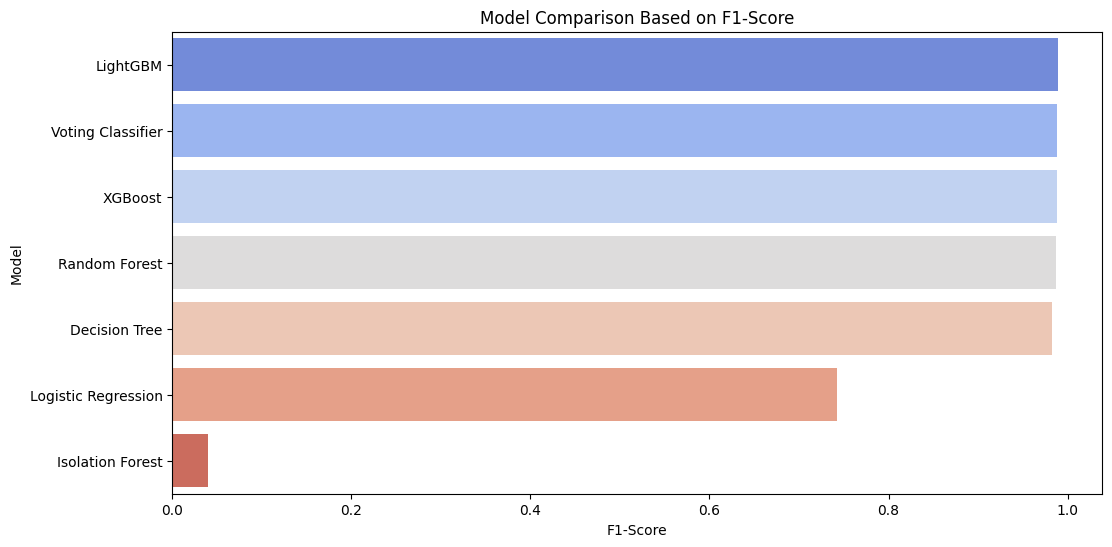

In [34]:
# Convert results to a DataFrame and sort by F1-score
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)

print(tabulate(results_df, headers='keys', tablefmt='fancy_grid'))

# Plot F1-Score comparison using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='F1-Score', y='Model', data=results_df, palette='coolwarm')
plt.title('Model Comparison Based on F1-Score')
plt.show()

**CONCLUSION:**

*  Based on the comparison of multiple machine learning algorithms, LightGBM emerged as the most suitable model for this online payments fraud detection task.

* LightGBM outperforms the other models in terms of the evaluated metrics.


*   It ensures a balance between detecting fraudulent transactions and minimizing false alarms, making it the most reliable model compared to others like Decision Tree, Random Forest, and Logistic Regression.





**USING LIGHTGBM:**

**METRICS BEFORE HYPERPARAMETER TUNING:**

In [90]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

# Initial LightGBM model
initial_model = lgb.LGBMClassifier(random_state=42)
initial_model.fit(X_train, y_train)

# Predictions and evaluation before tuning
y_pred_initial = initial_model.predict(X_val)
accuracy_initial = accuracy_score(y_val, y_pred_initial)
precision_initial = precision_score(y_val, y_pred_initial)
recall_initial = recall_score(y_val, y_pred_initial)
f1_initial = f1_score(y_val, y_pred_initial)

print("Before Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_initial:.2f}")
print(f"Precision: {precision_initial:.2f}")
print(f"Recall: {recall_initial:.2f}")
print(f"F1 Score: {f1_initial:.2f}")


Before Hyperparameter Tuning:
Accuracy: 0.99
Precision: 0.98
Recall: 1.00
F1 Score: 0.99


**HYPERPARAMETER TUNING**


In [91]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import time

# Define a reduced parameter grid to confirm it's running as expected
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

# Start a timer
start_time = time.time()

# Grid search with LightGBM
grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Print best hyperparameters and time taken
print("Best Hyperparameters:", grid_search.best_params_)
print("Time taken: {:.2f} seconds".format(time.time() - start_time))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
Time taken: 16.80 seconds


In [92]:
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

Best Accuracy: 0.99


**METRICS AFTER HYPERPARAMETER TUNING:**

In [93]:
# Predictions and evaluation after tuning
y_pred_tuned = best_model.predict(X_val)
accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
precision_tuned = precision_score(y_val, y_pred_tuned)
recall_tuned = recall_score(y_val, y_pred_tuned)
f1_tuned = f1_score(y_val, y_pred_tuned)

print("\nAfter Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_tuned:.2f}")
print(f"Precision: {precision_tuned:.2f}")
print(f"Recall: {recall_tuned:.2f}")
print(f"F1 Score: {f1_tuned:.2f}")



After Hyperparameter Tuning:
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


**COMPARISON - BEFORE AND AFTER HYPERPARAMETER TUNING:**

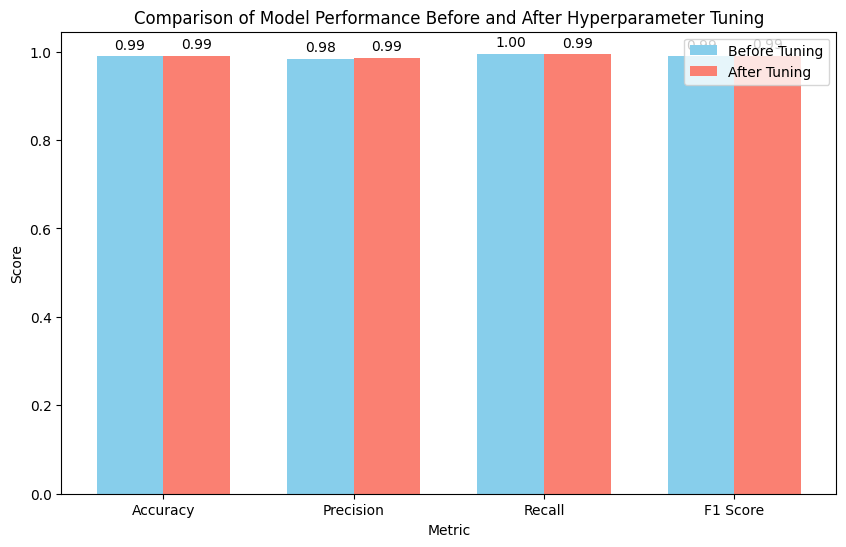

In [58]:
# Metrics before and after tuning
metrics_before = [accuracy_initial, precision_initial, recall_initial, f1_initial]
metrics_after = [accuracy_tuned, precision_tuned, recall_tuned, f1_tuned]
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Bar plot
x = np.arange(len(metric_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, metrics_before, width, label='Before Tuning', color='skyblue')
bar2 = ax.bar(x + width/2, metrics_after, width, label='After Tuning', color='salmon')

# Labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance Before and After Hyperparameter Tuning')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()

# Display values on bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


**TRANING THE MODEL**

*   Printing **VALIDATION ACCURACY**
*   Printing **TEST ACCURACY**



In [94]:

# Use the best hyperparameters found in the grid search
best_params = grid_search.best_params_

# Initialize the LightGBM classifier with the best parameters
model = lgb.LGBMClassifier(**best_params, random_state=42)

# Train the model with early stopping
# The 'verbose' argument is moved to the 'lgb.early_stopping' callback.
# The 'lgb.early_stopping' callback is already set to 'verbose_eval=10', which controls output frequency.
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],           # Validation set for early stopping
    eval_metric='logloss',                # Evaluation metric for early stopping
    # early_stopping_rounds=10,          # Removed 'early_stopping_rounds' from here
    callbacks=[lgb.early_stopping(10, verbose=True)],  # Added early stopping as a callback with verbose
    # verbose=True                          # Removed 'verbose' argument from here
)

# Evaluate model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_precision * 100:.2f}%")
print(f"Validation Recall: {val_recall * 100:.2f}%")
print(f"Validation F1 Score: {val_f1 * 100:.2f}%")

# Test the model on the test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTest Set Evaluation:")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")
print(f"Test F1 Score: {test_f1 * 100:.2f}%")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.045622
Validation Accuracy: 98.70%
Validation Precision: 97.88%
Validation Recall: 99.50%
Validation F1 Score: 98.69%

Test Set Evaluation:
Test Accuracy: 98.74%
Test Precision: 98.21%
Test Recall: 99.37%
Test F1 Score: 98.79%


**CONFUSION MATRIX:**

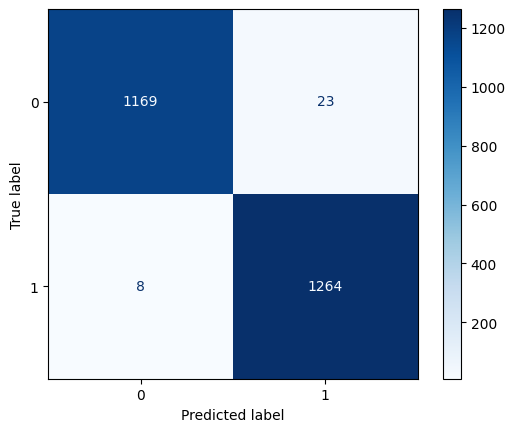

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust labels as necessary
disp.plot(cmap=plt.cm.Blues)
plt.show()


**SHOWING FEATURE IMPORTANCE:**

**TESTING THE MODEL BY GIVING INPUTS:**

**STATIC INPUTS:**

In [105]:
t=np.array([[0,76550.74	,	1096252.93,2132233.28	]])
# Use the fitted model 'best_xgb_model' for prediction
print(model.predict(t))
if(model.predict(t)==0):
  print("Not Fraud")
else:
  print("Fraud")

[0.]
Not Fraud


In [111]:
t=np.array([[4,22877.00,22877.00	,0	]])
# Use the fitted model 'best_xgb_model' for prediction
print(model.predict(t))
if(model.predict(t)==0):
  print("Not Fraud")
else:
  print("Fraud")

[1.]
Fraud


In [112]:
t=np.array([[1,4738282.28,4738282.28	,4738282.28]])
# Use the fitted model 'best_xgb_model' for prediction
print(model.predict(t))
if(model.predict(t)==0):
  print("Not Fraud")
else:
  print("Fraud")

[1.]
Fraud


**INPUTS FROM THE USER:**(Dynamic inputs)

In [116]:
# Define a function to get user input and predict fraud
def get_user_input_and_predict(model):
    # Get user input
    transaction_type = input("Enter the type of transaction (e.g., 'CASH_IN', 'CASH_OUT', etc.): ")
    amount = float(input("Enter the transaction amount: "))
    oldbalanceOrg = float(input("Enter the old balance of the origin account: "))
    newbalanceDest = float(input("Enter the new balance of the destination account: "))

    # Prepare the input for the model
    features = {
        'type': transaction_type,
        'amount': amount,
        'oldbalanceOrg': oldbalanceOrg,
        'newbalanceDest': newbalanceDest
    }

    # Convert categorical features into numerical format as required by the model
    # Adjusting encoding based on your model's training
    transaction_types = {
        'CASH_IN': 0,
        'CASH_OUT': 1,
        'DEBIT': 2,
        'PAYMENT': 3,
        'TRANSFER': 4
    }  # Include all types that your model recognizes

    # Encode the transaction type
    type_encoded = transaction_types.get(transaction_type, -1)  # Use -1 for unknown types

    # Check if type_encoded is -1 which indicates an unknown type
    if type_encoded == -1:
        print(f"Unknown transaction type: {transaction_type}. Please enter a valid type.")
        return

    # Create a feature array
    X_new = np.array([[type_encoded, amount, oldbalanceOrg, newbalanceDest]])

    # Debugging: print the feature array and model prediction
    print("Features for prediction:", X_new)

    # Make prediction
    prediction = model.predict(X_new)

    # Output the result
    if prediction[0] == 1:
        print("The transaction is predicted to be fraudulent.")
    else:
        print("The transaction is predicted to be legitimate.")

# Call the function to test the model with user input
get_user_input_and_predict(model)


Enter the type of transaction (e.g., 'CASH_IN', 'CASH_OUT', etc.): CASH_IN
Enter the transaction amount: 76550.74
Enter the old balance of the origin account: 1096252.93
Enter the new balance of the destination account: 2132233.28
Features for prediction: [[      0.     76550.74 1096252.93 2132233.28]]
The transaction is predicted to be legitimate.


**MODEL DEPLOYMENT:**

In [121]:
import joblib
joblib.dump(model, 'lightgbm_model.pkl')


['lightgbm_model.pkl']